# A Simple Demo of OOD Attack
### Note: put this file "demo.ipynb" into the folder  OOD_Attack_NN/app/BS

In [1]:
import sys
sys.path.append('../../core')
#%%
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tv_transforms
import skimage
import skimage.io as io
import skimage.transform as sk_transform
import argparse
from sklearn.metrics import roc_curve, roc_auc_score
from RobustDNN_PGD_OOD import pgd_attack
from Evaluate import test

In [2]:
#%% you need to install or download the models from advertorch
from advertorch_examples.models import get_cifar10_wrn28_widen_factor
def Net(name):
    return get_cifar10_wrn28_widen_factor(4)
#%%
def load_dataset(data_path, batch_size, num_workers):
    dataset = torchvision.datasets.CIFAR10(root=data_path, download=True, train=False,
                                           transform=tv_transforms.ToTensor())
    loader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=False)
    return loader
#%%
def attack(model, x1, x2, noise_norm, norm_type, max_iter, step):
    xn=pgd_attack(model, x1, None, x2,
                  noise_norm=noise_norm, norm_type=norm_type,
                  max_iter=max_iter, step=step, use_optimizer=True)
    return xn
#%%
def compute_ood_score(model, x):
    #An OOD sample should have a higher score
    #x.shape  N x K
    #N is number of data samples
    #K is number of classes
    x=model(x)
    prob=F.softmax(x, dim=1)
    MaxSoftmax=prob.max(dim=1)[0]
    MaxSoftmax=MaxSoftmax.detach().cpu().numpy()
    score=1-MaxSoftmax
    return score
#%%
def plot_ood(OODScoreIn, OODScoreOut, ax=None):
    label_out=np.ones(OODScoreOut.shape)
    label_in=np.zeros(OODScoreIn.shape)
    label=np.concatenate([label_out, label_in])
    score21=np.concatenate([OODScoreOut, OODScoreIn])
    fpr, tpr, thresholds = roc_curve(label, score21, pos_label=1)
    auc_ood=roc_auc_score(label, score21)
    print('auc_ood', auc_ood)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xlim(0, 1);
    ax.set_ylim(0, 1.01);
    ax.grid(True)
    ax.plot(fpr, tpr)
    #ax.set_yticks(np.arange(0, 1.05, step=0.05));
    ax.set_title('AUC='+ '{:.3f}'.format(auc_ood))
    ax.set_aspect('equal')
    plt.show()
    return ax.figure, ax, auc_ood

In [3]:
#parser = argparse.ArgumentParser(description='Input Parameters:')
#parser.add_argument('--cuda_id', default=0, type=int)
#parser.add_argument('--net_name', default='wrn', type=str)
#parser.add_argument('--ood_name', default='color-spiral-1', type=str)
#arg = parser.parse_args()
class ARG:
    def __init__(self):
        self.cuda_id=0
        self.net_name='wrn'
        self.ood_name='color-spiral-1'
arg=ARG()

In [10]:
device=torch.device('cuda:'+str(arg.cuda_id) if torch.cuda.is_available() else "cpu")
net_name=arg.net_name
ood_name=arg.ood_name
#-------------------------------------------
model = Net(net_name)
model.load_state_dict(torch.load('CIFAR10_mmacifar10_ce_SGD_epoch199.pt')['model_state_dict'])
model.eval()
model.to(device);

In [5]:
loader=load_dataset('data', 128, 0)
#%% test acc 0.9402
#result_test=test(model, device, loader, 10)

Files already downloaded and verified


C:\Programs\anaconda3\envs\pytorch1.8\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


ood_score_x1 [6.4373016e-06]


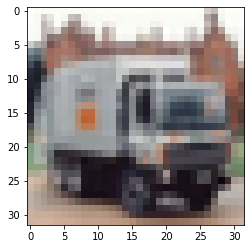

In [6]:
#get an IND sample, idx=1, 10, 100
idx1=11
x1=loader.dataset[idx1][0]
x1=torch.tensor(x1.reshape(1,3,32,32), device=device).contiguous()
xx1=x1.detach().cpu().numpy().reshape(3,32,32).transpose(1,2,0)
plt.imshow(xx1)
ood_score_x1 = compute_ood_score(model, x1)
print('ood_score_x1', ood_score_x1)

ood_score_x2 [0.00197035]


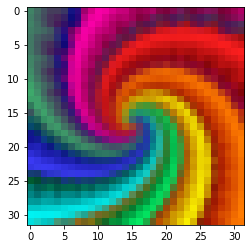

In [7]:
#generate the initial OOD sample: rand or color-spiral-1
if ood_name != 'rand':
    x2=io.imread('../../data/'+ood_name+'.jpg')
    x2=skimage.util.img_as_float32(x2)
    x2=sk_transform.resize(x2, [32,32])
    x2=(x2-x2.min())/(x2.max()-x2.min())
    x2=x2.transpose(2,0,1)
else:
     x2=np.random.rand(3,32,32).astype('float32')
x2=torch.tensor(x2.reshape(1,3,32,32), device=device).contiguous()
xx2=x2.detach().cpu().numpy().reshape(3,32,32).transpose(1,2,0)
plt.imshow(xx2, cmap='gray')
ood_score_x2 = compute_ood_score(model, x2)
print('ood_score_x2', ood_score_x2)

In [8]:
#perform OOD attack
start = time.time()
noise_norm=10
norm_type=2
max_iter=100
step=noise_norm/100
xn=attack(model, x1, x2, noise_norm, norm_type, max_iter, step)
zn=model(xn)
z1=model(x1).detach()
z2=model(x2).detach()
MAPE = (torch.mean(torch.abs(zn-z1))/torch.max(torch.abs(z1))).item()
print('MAPE', MAPE)
ood_score_xn = compute_ood_score(model, xn)
print('ood_score_xn', ood_score_xn)
end = time.time()
print('time cost:', end - start)
print('norm:', torch.norm(xn-x2, p=norm_type).item())

MAPE 0.003392489394173026
ood_score_xn [6.4373016e-06]
time cost: 2.226752996444702
norm: 9.994126319885254


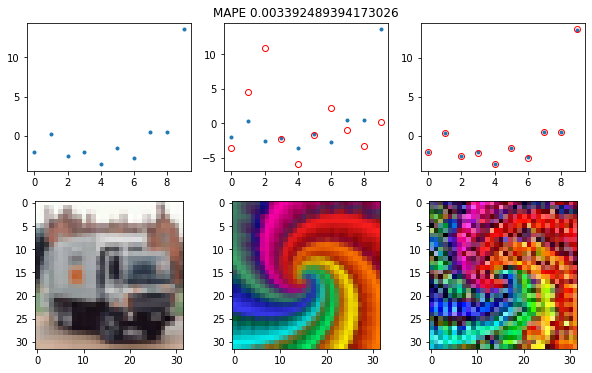

In [9]:
fig, ax =plt.subplots(2,3, figsize=(10, 6))
ax[0,0].plot(z1.squeeze().detach().cpu().numpy(), '.')
ax[0,1].plot(z1.squeeze().detach().cpu().numpy(), '.')
ax[0,1].plot(z2.squeeze().detach().cpu().numpy(), 'or', fillstyle='none');
ax[0,2].plot(z1.squeeze().detach().cpu().numpy(), '.')
ax[0,2].plot(zn.squeeze().detach().cpu().numpy(), 'or', fillstyle='none');
ax[0,1].set_title('MAPE '+str(MAPE))
ax[1,0].imshow(x1.squeeze().detach().cpu().numpy().transpose(1,2,0))
ax[1,1].imshow(x2.squeeze().detach().cpu().numpy().transpose(1,2,0))
ax[1,2].imshow(xn.squeeze().detach().cpu().numpy().transpose(1,2,0))